# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

QURESHI, Junaid, 2149457

ARSENAULT, Charles, 2142426

Note finale :

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [1]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

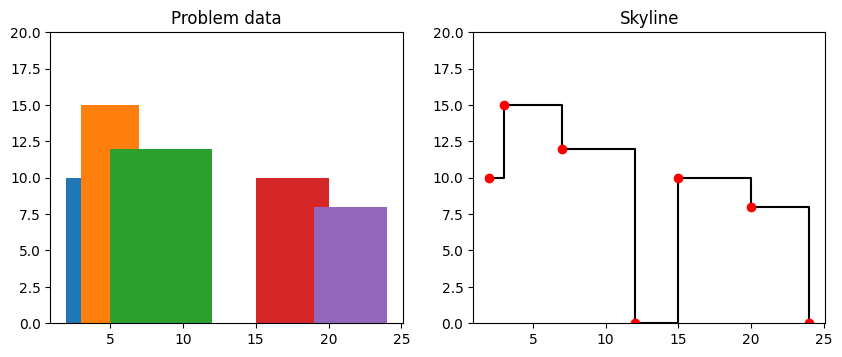

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]
axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [3]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

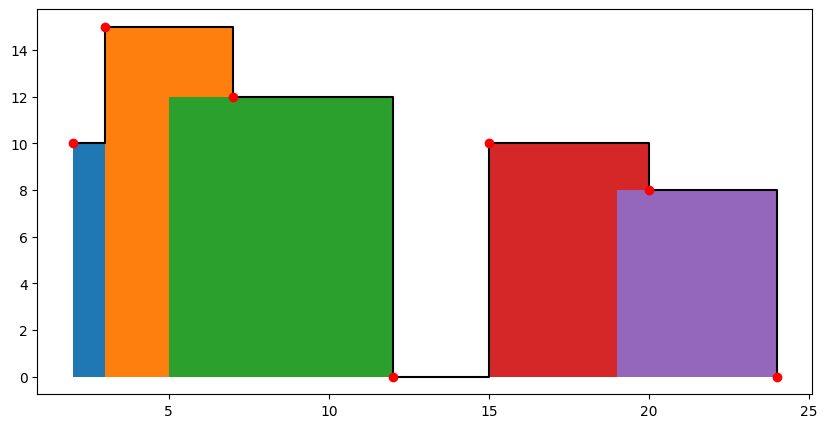

In [5]:
def skyline_bruteforce(buildings):
    # TODO : Implantez un algorithme naïf
    skyline = []
    currentHeight = 0
    max = 0
    
    for i in range(len(buildings)):
        if buildings[i][1] > max:
            max = buildings[i][1]
            
    for i in range (0, max):
        height = 0
        for j in range(len(buildings)):
            if i >= buildings[j][0] and i < buildings[j][1]:
                if buildings[j][2] >= height:
                    height = buildings[j][2] 
                    
        if currentHeight != height:
            currentHeight = height
            skyline.append([i, height])
            
        if i == max - 1:
            skyline.append([i + 1, 0])
        
    return skyline


verification_plot(example_buildings, skyline_bruteforce(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

La complexité asymptotique du temps de l'algorithme est en effet O(w * n), où w représente la largeur de la ligne d'horizon (dans ce cas, 50) et n représente le nombre de bâtiments dans la liste d'entrée. Cette complexité provient des boucles imbriquées, où la boucle extérieure itère sur les différentes positions de 0 à w, et la boucle intérieure itère sur les n bâtiments. Avec une longueur indéfinie de  la ligne d'horizon, on peut supposer que la complexité asymptotique temporelle est O(n^2).

### Mesures

In [302]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2149457, [400,500,600,700,800,900,1000,1100,1200])

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [303]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

In [304]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
400          0.12744131088256835
500          0.22980666160583496
600          0.31673321723937986
700          0.42142653465270996
800          0.4616398334503174
900          0.5814041137695313
1000         0.6759005069732666
1100         0.8324471950531006
1200         1.021645975112915


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

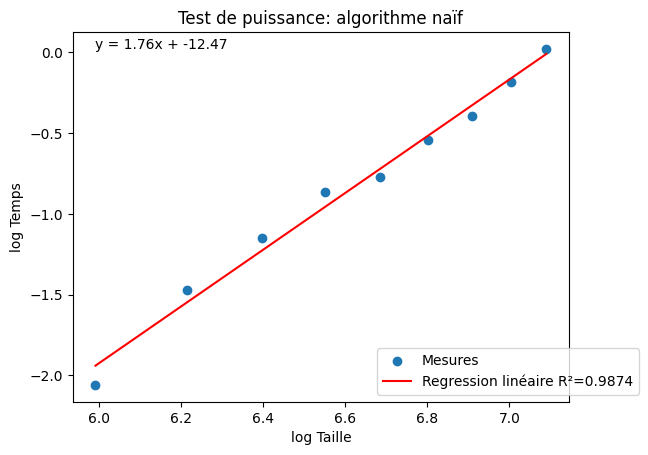

In [305]:
import math

def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Nous observons une courbe qui présente une tendance relativement linéaire, ce qui indique que notre algorithme est polynomial. Cette observation est cohérente puisque le logarithme d'un polynôme est lui-même linéaire.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

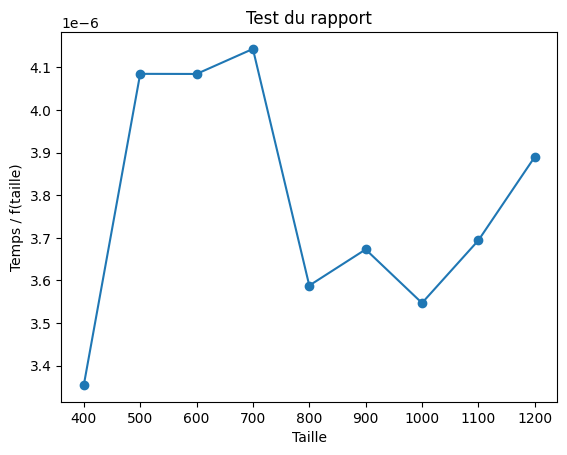

In [306]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : measure/f(size)
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x**1.76
display_test_rapport(values_test_rapport(measures_bruteforce, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

Malgré une dispersion apparente des points, une tendance à la convergence se dégage du graphique. Les derniers points varient dans une petite intervalle, entre 3.6 et 3.8 à 1e-6. Cette convergence suggère une estimation correcte de la fonction.

La relation entre les variables peut être modélisée par l'équation y = ax^m. En prenant le logarithme des deux côtés, on obtient log(y) = log(a) + mlog(x). En considérant cela, si nous analysons l'équation de la droite obtenue par le test de puissance, nous pouvons déterminer que la valeur de m est égale à 1.76. Par conséquent, nous pouvons conclure que f(x) = x^1.76.

Il convient de noter que cette valeur peut varier considérablement en fonction de la taille et de la quantité des échantillons utilisés, ainsi que des conditions dans lesquelles ils sont testés.


### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

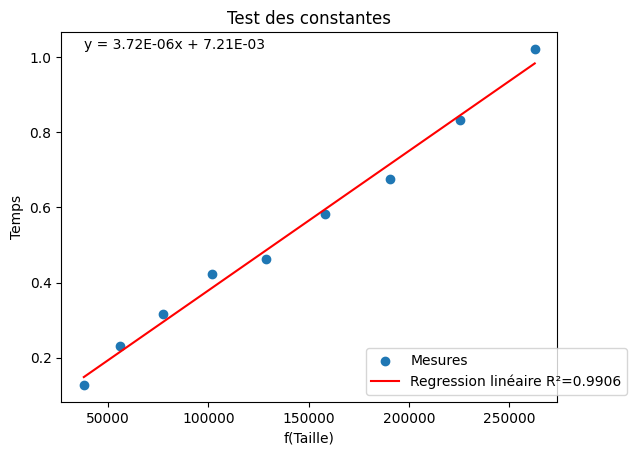

In [307]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return x**1.76

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Une fois de plus, la courbe de ce graphique est bien linéaire, ce qui suggère que le modèle que nous avons utilisé est correct. De plus, la valeur de la pente de ce graphique donnée par l'équation (3.72 1e-6) semble correspondre à la valeur de covergence observée dans le test de rapport.




## Partie 2 : Algorithme diviser pour régner (5 pts)


<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

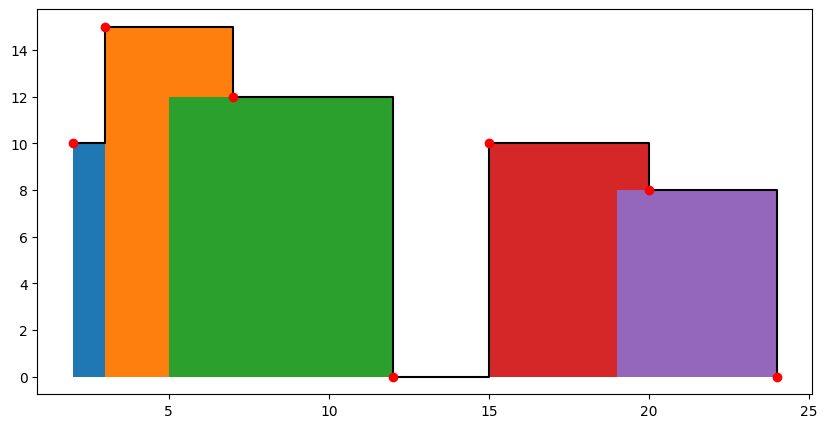

In [12]:
def skyline_divide_and_conquer(buildings):
    # TODO: Implantez un algorithme diviser-pour-régner
    n = len(buildings)
    if n == 0:
        return skyline
    if n == 1:
        left, right, height = buildings[0]
        return [[left, height], [right, 0]]

    #séparer les buildings en 2 et les résoudre récursivement
    left = skyline_divide_and_conquer(buildings[:n // 2])
    right = skyline_divide_and_conquer(buildings[n //2:])

    return combine(left, right)

def combine(left: list[list[int]], right: list[list[int]]):
    res = []
    i = 0
    j = 0
    leftY = 0
    rightY = 0

    while i < len(left) and j < len(right):
        if left[i][0] < right[j][0]:
            leftY = left[i][1]
            res = addPoint(res, left[i][0], max(left[i][1], rightY))
            i += 1
        else:
            rightY = right[j][1]
            res = addPoint(res, right[j][0], max(right[j][1], leftY))
            j += 1

    while i < len(left):
        res = addPoint(res, left[i][0], left[i][1])
        i +=1

    while j < len(right):
        res = addPoint(res, right[j][0], right[j][1])
        j += 1
    return res

def addPoint(res: list[list[int]], x: int, y: int):
    if res and res[-1][0] == x:
        res[-1][1] = y
        return res
    if res and res[-1][1] == y:
        return res

    res.append([x, y])
    return res

verification_plot(example_buildings, skyline_divide_and_conquer(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

Contrairement au premier algorithme, celui-ci a une complexité asymptotique de O(n*log(n)). La raison en est le processus de division par deux du tableau. 

Le traitement et la combinaison des sous-tableaux s'effectuent en temps linéaire, puisque chaque élément doit être traité. Cependant, comme le problème est divisé en deux à chaque niveau de récursivité et que le nombre de niveaux dans l'arbre de récursivité est logarithmique, la complexité globale de l'algorithme est O(n*log(n)).

### Mesures (seuil 1)

In [214]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2149457, [10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000])

In [215]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)

In [216]:
display_measures_table(measures_divide_naive_threshold)

Taille       Temps moyen (s)
10000        0.09721503257751465
15000        0.15722503662109374
20000        0.25179309844970704
25000        0.33924360275268556
30000        0.3988492488861084
35000        0.44665040969848635
40000        0.5193090438842773
45000        0.6280346870422363
50000        0.7415276527404785
55000        0.8273643493652344
60000        0.8347867488861084
65000        0.9198442459106445
70000        0.9966662883758545
75000        1.1172774314880372


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

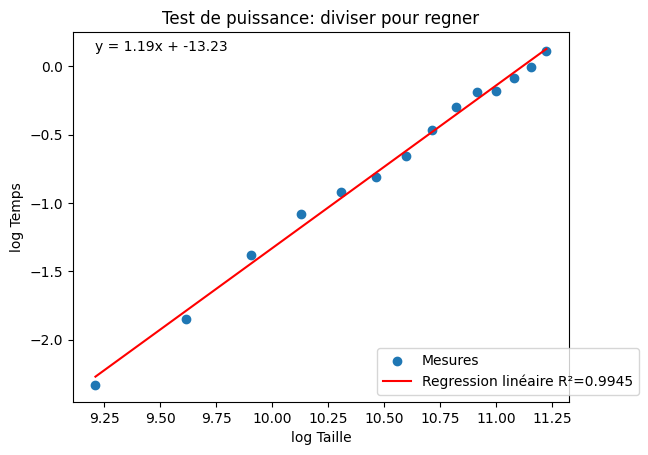

In [217]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: diviser pour régner")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Nous remarquons que c'est une courbe linéaire, ce qui signifie que notre algorithme est polynomial. Multiplier x par son logarithme est toujours un polynôme même s'il y a un logarithme dans l'équation. 

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

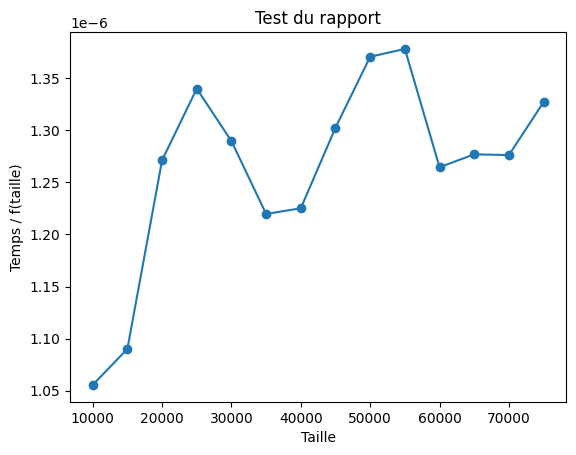

In [313]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Encore une fois, malgré une dispersion apparente des points, une tendance à la convergence se dégage du graphique. Les derniers points varient dans une petite intervalle, entre 1.25 et 1.35 à 1e-6. Cette convergence suggère une estimation correcte de la fonction.

En ce qui concerne la fonction, nous avons décidé d'utiliser x * log(x) au lieu de la valeur m pour la puissance de x, car cela représente mieux la complexité temporelle de l'algorithme. 


### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

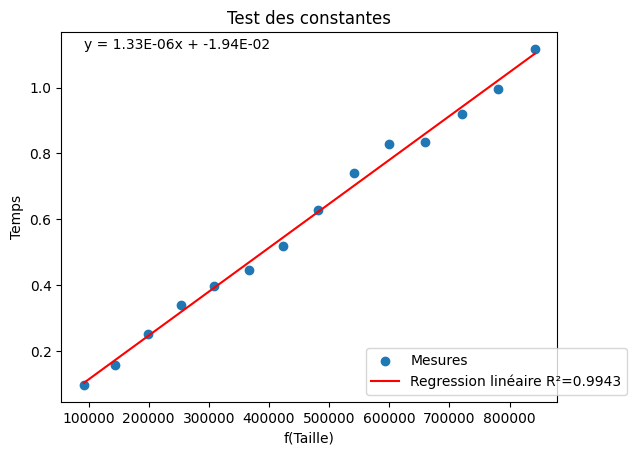

In [314]:
# TODO: définissez f judicieusement
def f(x):
    return x * math.log(x)

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Une fois de plus, la courbe de ce graphique est bien linéaire, ce qui suggère que le modèle que nous avons utilisé est correct. De plus, la valeur de la pente de ce graphique donnée par l'équation (1.33 1e-6) semble correspondre à la valeur de covergence observée dans le test de rapport.

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

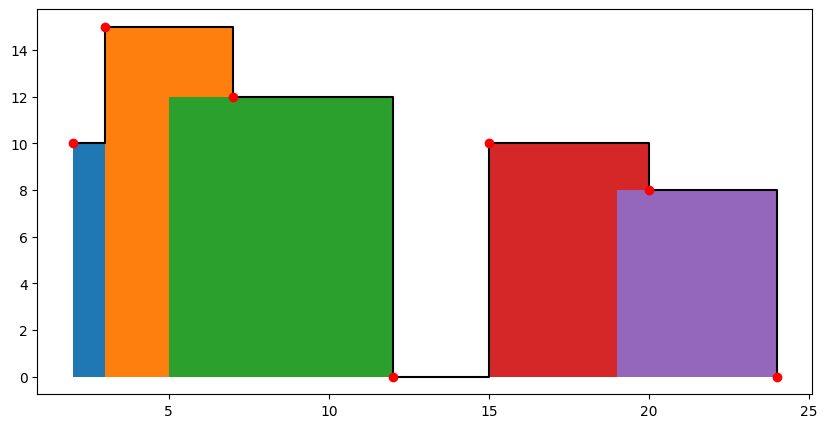

In [397]:
def skyline_divide_and_conquer_threshold(buildings, threshold):
    n = len(buildings)
    if n <= threshold:
        return skyline_bruteforce(buildings)

    #séparer les buildings en 2 et les résoudre récursivement
    left = skyline_divide_and_conquer_threshold(buildings[:n // 2], threshold)
    right = skyline_divide_and_conquer_threshold(buildings[n //2:], threshold)

    return combine(left, right)

def combine(left: list[list[int]], right: list[list[int]]):
    res = []
    i = 0
    j = 0
    leftY = 0
    rightY = 0

    while i < len(left) and j < len(right):
        if left[i][0] < right[j][0]:
            leftY = left[i][1]
            res = addPoint(res, left[i][0], max(left[i][1], rightY))
            i += 1
        else:
            rightY = right[j][1]
            res = addPoint(res, right[j][0], max(right[j][1], leftY))
            j += 1

    while i < len(left):
        res = addPoint(res, left[i][0], left[i][1])
        i +=1

    while j < len(right):
        res = addPoint(res, right[j][0], right[j][1])
        j += 1
    return res

def addPoint(res: list[list[int]], x: int, y: int):
    if res and res[-1][0] == x:
        res[-1][1] = y
        return res
    if res and res[-1][1] == y:
        return res

    res.append([x, y])
    return res

verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, 5))

<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [428]:
taille = 500
data_set = get_dataset(2149457, [taille])
thresholds_to_test = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]

measures_threshold = {
    i: measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        data_set[taille])
    for i in thresholds_to_test
}

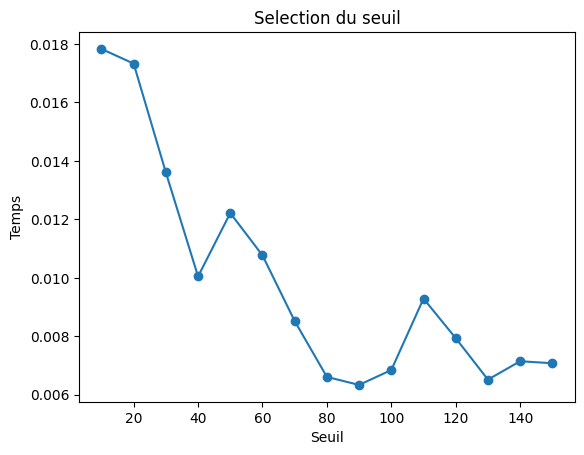

In [429]:
display_mesures_seuil(measures_threshold)

<u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

Bien qu'il y ait beaucoup de variations, le seuil qui semble le plus consistant après de nombreux échantillons est celui de 90. La façon dont nous avons choisi le seuil idéal est en sélectionnant celui avec le temps le plus bas qui se trouve dans un creux dans le graphique. Cette méthode permet d'éliminer les écarts aléatoires. 


La raison pour laquelle les valeurs inférieures à ce seuil sont moins performantes est qu'à partir d'une certaine taille de tableau (le seuil), l'algorithme "diviser pour régner" devient moins performant que l'approche naïve. C'est logique, car x^2 < x * log(x) pour une certaine plage de valeurs.  Ainsi, si nous utilisons l'algorithme "diviser pour régner" alors que l'approche naif est plus rapide, nous perdrons en performance.


Quant aux valeurs supérieures au seuil, elles sont plus lentes parce que l'algorithme naif est simplement plus lent plus la valeur est élevée. Après la valeur du seuil, nous voyons pourquoi O(n*log(n)) est souvent souhaité.  



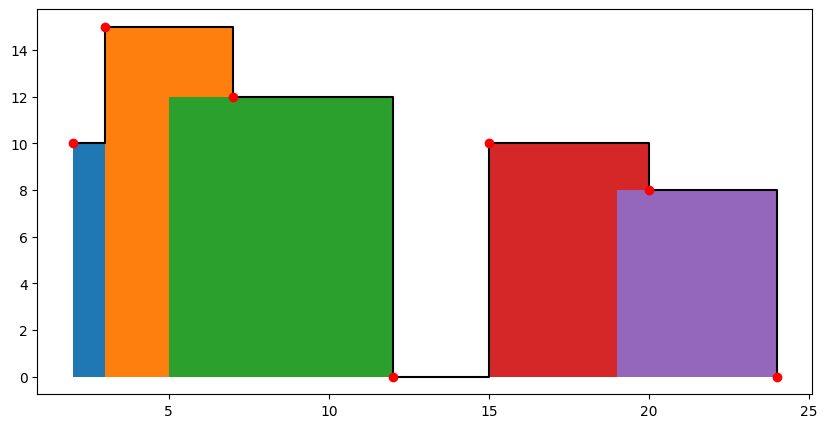

In [430]:
best_threshold = 90
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

Même si nous implémentons un seuil dans cet algorithme, nous cherchons une limite supérieure, qui reste à O(n *log(n)). La justification est la même que pour le dernier algorithme.

### Mesures (seuil n)

In [437]:
dataset = get_dataset(2149457, [1000,1500,2000,2500,3000,3500,4000,4000,5000])
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [438]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
1000         0.022399234771728515
1500         0.03234391212463379
2000         0.041860342025756836
2500         0.06576418876647949
3000         0.1231870174407959
3500         0.09628548622131347
4000         0.11175746917724609
5000         0.10067477226257324


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

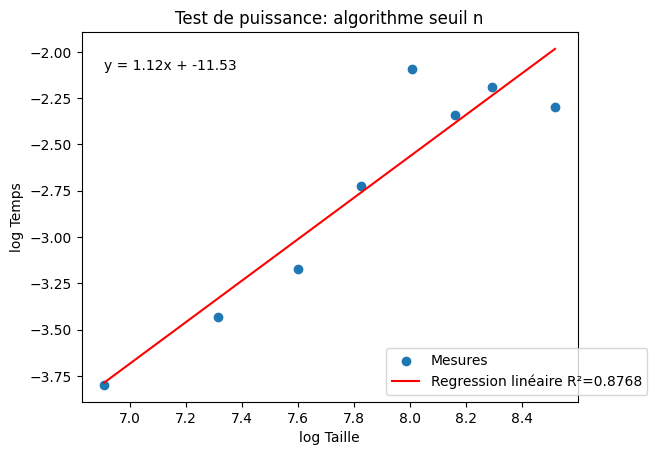

In [439]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Une fois de plus, nous pouvons voir la tendance linéaire de la courbe, ce qui signifie que l'algorithme est polynomial. Cependant, on remaraque que la pente obtenu abrupt que l'algorithme sans seuil. 

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

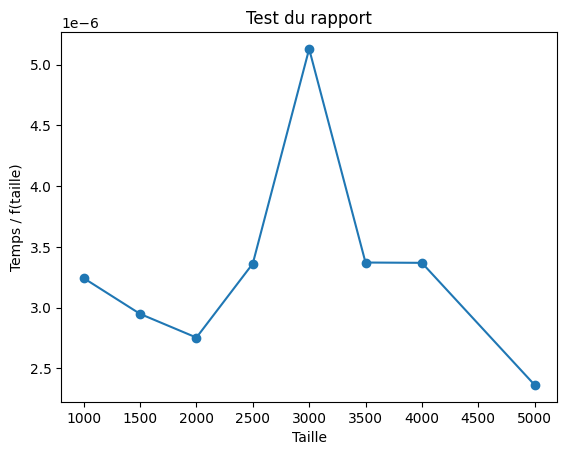

In [440]:
# TODO: définissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Encore une fois, malgré une dispersion apparente des points, une tendance à la convergence se dégage du graphique. Les derniers points varient dans une petite intervalle, entre 2.5 et 3.5 à 1e-6. Cette convergence suggère une estimation correcte de la fonction.

En ce qui concerne la fonction, nous avons décidé d'utiliser x * log(x) au lieu de la valeur m pour la puissance de x, car cela représente mieux la complexité temporelle de l'algorithme. 

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

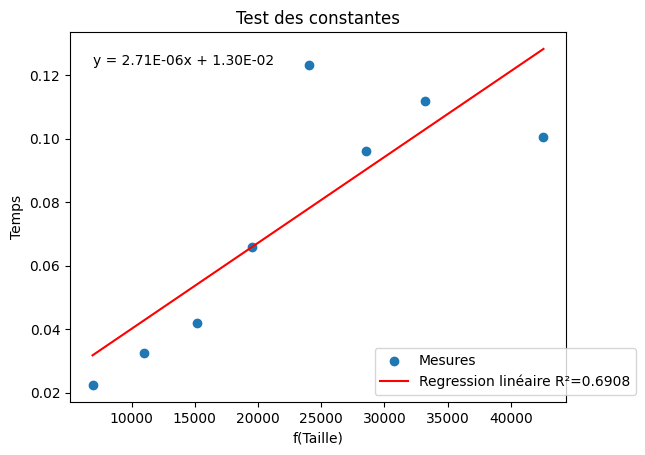

In [441]:
# TODO: définissez f judicieusement
def f(x):
    return x*math.log(x)

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

La ligne n'est pas entièrement linéaire, mais en raison des différentes variables de l'environnement de test, on peut supposer que la courbe est suffisamment linéaire pour le modèle. De plus, la valeur de la pente de ce graphique donnée par l'équation (2.71 1e-6) semble correspondre à la valeur de covergence observée dans le test de rapport.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?
Le seuil semble avoir légèrement amélioré la durée d'exécution de l'algorithme par rapport à celui qui n'utilise pas de seuils. Cependant, l'augmentation est très faible et le fait de refaire les tests peut conduire à des résultats différents. 

Ce seuil représente l'intersection qui sépare la plage de valeurs pour laquelle un algorithme a un meilleur temps d'exécution que l'autre. En effet, comme l'algorithme diviser pour régner a une complexité temporelle de 0(n * log(n)) et l'autre de O(n^2), toute valeur inférieure au seuil signifie que n^2 < n * log(n) et vice-versa. 


# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.